<a href="https://colab.research.google.com/github/ferdaous-mz/ML-Preprocessing-Feature-Extraction-and-Model-Evaluation/blob/main/Final_Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ********************************************************* Section 1: Data Preprocessing ***************************************************************************
# Step 1: Setting up the environment
# Installing necessary libraries
#!pip install pandas numpy scikit-learn matplotlib seaborn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Step 2: Loading the HIGGS dataset (sample 100,000 rows)
# Loading only a sample from the dataset

# URL of the HIGGS dataset (.csv.gz format)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"

# Load first 100000 rows directly from the compressed file
df = pd.read_csv(url, compression='gzip', header=None, nrows=100000)

# Name the columns
df.columns = ['label'] + [f'feature_{i}' for i in range(1, 29)]

# Check the shape
print(df.shape)
df.head()


(100000, 29)


,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [4]:
# Step 3: Outlier Analysis (IQR Method)
def remove_outliers_iqr(df, feature_cols):
    cleaned_df = df.copy()
    for col in feature_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Optional: cap instead of remove
        cleaned_df[col] = np.where(cleaned_df[col] < lower_bound, lower_bound,
                            np.where(cleaned_df[col] > upper_bound, upper_bound, cleaned_df[col]))
    return cleaned_df

# Apply IQR outlier handling to all feature columns
feature_cols = df.columns[1:]  # exclude label
df_clean = remove_outliers_iqr(df, feature_cols)


In [5]:
# Step 4: Feature Scaling (MinMaxScaler)
scaler = MinMaxScaler()
df_scaled = df_clean.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_clean[feature_cols])

# Check the result
df_scaled.describe().T

# Saving the preprocessed data to a new CSV to use in later steps
df_scaled.to_csv('higgs_preprocessed.csv', index=False)


In [6]:
# ********************************************************** Section 2: Feature Selection  ****************************************************************
# Required imports
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Splitting data into features and target
X = df_scaled.drop('label', axis=1)
y = df_scaled['label']


In [7]:
# Selectting top 15 features using Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=15)
X_mi_selected = selector_mi.fit_transform(X, y)

# Getting the selected feature names
selected_features_mi = X.columns[selector_mi.get_support()]
print("Top 15 Features using Mutual Information:\n", selected_features_mi.tolist())


Top 15 Features using Mutual Information:
 ['feature_1', 'feature_2', 'feature_4', 'feature_6', 'feature_8', 'feature_9', 'feature_13', 'feature_17', 'feature_19', 'feature_21', 'feature_23', 'feature_25', 'feature_26', 'feature_27', 'feature_28']


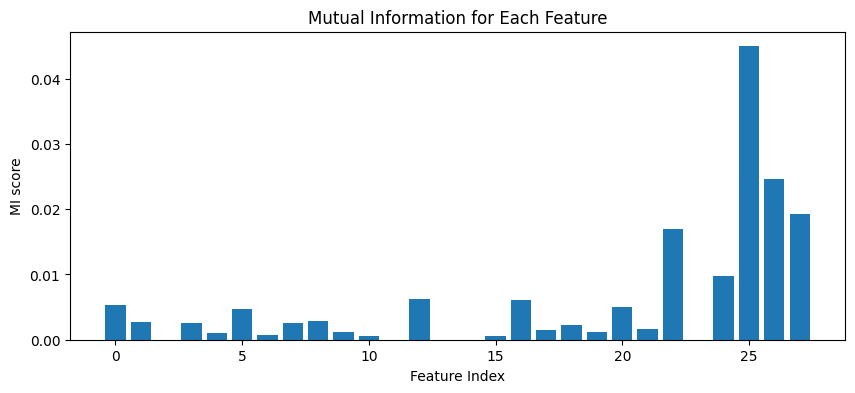

In [8]:
# Visualizing Feature Scores

# Plot Mutual Information scores
mi_scores = selector_mi.scores_
plt.figure(figsize=(10, 4))
plt.bar(range(len(mi_scores)), mi_scores)
plt.title("Mutual Information for Each Feature")
plt.xlabel("Feature Index")
plt.ylabel("MI score")
plt.show()


In [9]:
# Saving selected features for future use
# Create new DataFrames with selected features
X_selected_mi = df_scaled[selected_features_mi]

# Add labels back in
df_selected_mi = pd.concat([df_scaled['label'], X_selected_mi], axis=1)

# Save to CSV
df_selected_mi.to_csv("higgs_selected_mutual_info.csv", index=False)


In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ********************************************************** Section 3: Modeling & Evaluation  ****************************************************************
# ===============================================
# //////////// Flowchart A ////////////////////
# ===============================================
# Step 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import os
import time
import joblib  # to save models if needed

# Step 2: Loading preprocessed dataset
df = pd.read_csv("higgs_preprocessed.csv")
X = df.drop("label", axis=1)
y = df["label"]


In [ ]:
# Step 3: Evaluation Metrics Function (to be reused across cells)
def evaluate_metrics(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }



[KNN] Outer Fold 1

[KNN] Outer Fold 2

[KNN] Outer Fold 3

[KNN] Outer Fold 4

[KNN] Outer Fold 5


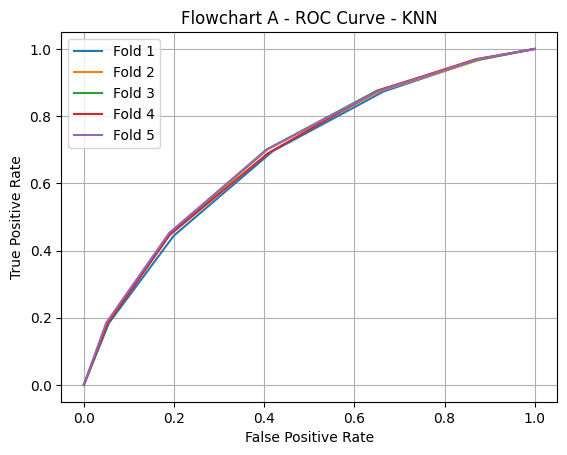

Total time: 625.62 seconds


In [ ]:
# Step 4: Run KNN Model from Flowchart A
MODEL_NAME = "KNN"
SAVE_PATH = f"/content/drive/MyDrive/flowchart_A_results_{MODEL_NAME}.csv"

fixed_params = {
    "KNN": {"n_neighbors": 5},
    "SVM": {"C": 1, "kernel": "rbf", "probability": True},
    "MLP": {"hidden_layer_sizes": (100,), "activation": "relu", "max_iter": 300},
    "XGBoost": {"use_label_encoder": False, "eval_metric": "logloss"}
}

models = {
    "KNN": KNeighborsClassifier,
    "SVM": SVC,
    "MLP": MLPClassifier,
    "XGBoost": XGBClassifier
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Force restart all folds regardless of previous progress
force_restart = True  # change to False to resume

if os.path.exists(SAVE_PATH) and not force_restart:
    results = pd.read_csv(SAVE_PATH).to_dict("records")
    start_fold = len(results) + 1
    print(f"Resuming from fold {start_fold}")
else:
    results = []
    start_fold = 1

model_class = models[MODEL_NAME]
start_time = time.time()
roc_data = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    if fold < start_fold:
        continue  # Skip completed folds

    print(f"\n[{MODEL_NAME}] Outer Fold {fold}")
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    best_features = None
    best_score = -np.inf
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=fold)

    for method in [mutual_info_classif, f_classif]:
        selector = SelectKBest(score_func=method, k=15)
        X_inner_selected = selector.fit_transform(X_train_outer, y_train_outer)
        model = model_class(**fixed_params[MODEL_NAME])
        score = cross_val_score(model, X_inner_selected, y_train_outer, cv=inner_cv, scoring="accuracy", n_jobs=-1).mean()
        if score > best_score:
            best_score = score
            best_features = selector.get_support()

    # Train final model
    X_train_final = X_train_outer.loc[:, best_features]
    X_test_final = X_test_outer.loc[:, best_features]
    model = model_class(**fixed_params[MODEL_NAME])
    model.fit(X_train_final, y_train_outer)
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]

    # Save ROC curve data
    fpr, tpr, _ = roc_curve(y_test_outer, y_proba)
    roc_data.append((fpr, tpr))

    # Save metrics
    metrics = evaluate_metrics(y_test_outer, y_pred, y_proba)
    results.append(metrics)

    # Save to CSV after each fold
    pd.DataFrame(results).to_csv(SAVE_PATH, index=False)

# Plot ROC curves after all folds
for i, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Fold {i+1}")
plt.title(f"Flowchart A - ROC Curve - {MODEL_NAME}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

print(f"Total time: {time.time() - start_time:.2f} seconds")



Resuming from fold 2

[SVM] Outer Fold 2

[SVM] Outer Fold 3

[SVM] Outer Fold 4

[SVM] Outer Fold 5


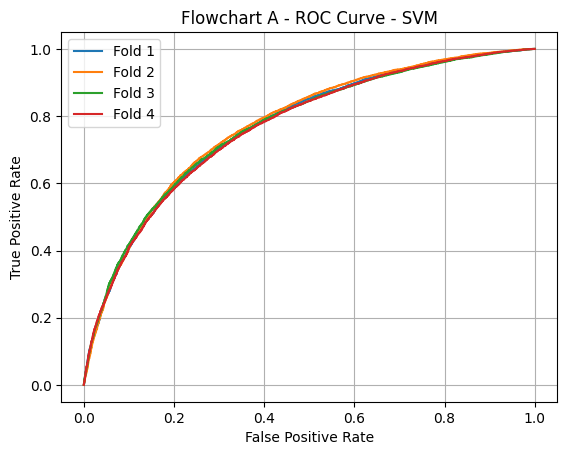

Total time: 8137.16 seconds


In [ ]:
# Step 5: Run SVM Model from Flowchart A
def evaluate_metrics(y_true, y_pred, y_score):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_score)
    }
MODEL_NAME = "SVM"
SAVE_PATH = f"/content/drive/MyDrive/flowchart_A_results_{MODEL_NAME}.csv"
fixed_params = {"C": 1, "kernel": "rbf"}  # removed probability=True

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Resume support
if os.path.exists(SAVE_PATH):
    results = pd.read_csv(SAVE_PATH).to_dict("records")
    start_fold = len(results) + 1
    print(f"Resuming from fold {start_fold}")
else:
    start_fold = 1

start_time = time.time()
roc_data = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    if fold < start_fold:
        continue

    print(f"\n[SVM] Outer Fold {fold}")
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    best_features = None
    best_score = -np.inf
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=fold)

    for method in [mutual_info_classif, f_classif]:
        selector = SelectKBest(score_func=method, k=15)
        X_selected = selector.fit_transform(X_train_outer, y_train_outer)
        model = SVC(**fixed_params)
        score = cross_val_score(model, X_selected, y_train_outer, cv=inner_cv, scoring="roc_auc", n_jobs=-1).mean()
        if score > best_score:
            best_score = score
            best_features = selector.get_support()

    # Final model
    selected_cols = X.columns[best_features]
    X_train_final = X_train_outer[selected_cols]
    X_test_final = X_test_outer[selected_cols]
    model = SVC(**fixed_params)
    model.fit(X_train_final, y_train_outer)
    y_pred = model.predict(X_test_final)

    # Use decision_function and scale to [0, 1] as ROC-AUC input
    decision_scores = model.decision_function(X_test_final)
    score_minmax = MinMaxScaler()
    y_proba_approx = score_minmax.fit_transform(decision_scores.reshape(-1, 1)).ravel()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_outer, y_proba_approx)
    roc_data.append((fpr, tpr))

    # Save metrics
    metrics = evaluate_metrics(y_test_outer, y_pred, y_proba_approx)
    results.append(metrics)
    pd.DataFrame(results).to_csv(SAVE_PATH, index=False)

# Plot ROC
for i, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Fold {i+1}")
plt.title(f"Flowchart A - ROC Curve - {MODEL_NAME}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

print(f"Total time: {time.time() - start_time:.2f} seconds")


[MLP] Outer Fold 1

[MLP] Outer Fold 2

[MLP] Outer Fold 3

[MLP] Outer Fold 4

[MLP] Outer Fold 5


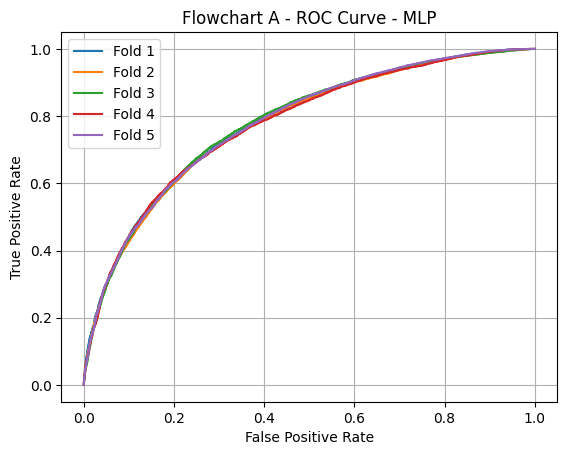

Total time: 479.65 seconds


In [ ]:
# Step 6: Running MLP Model from Flowchart A
# Defining metric evaluation
def evaluate_metrics(y_true, y_pred, y_score):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_score)
    }

# Load the preprocessed dataset
df = pd.read_csv("higgs_preprocessed.csv")
X = df.drop("label", axis=1)
y = df["label"]

# Model settings
MODEL_NAME = "MLP"
SAVE_PATH = f"/content/drive/MyDrive/flowchart_A_results_{MODEL_NAME}.csv"

# Define fixed parameters for MLP
mlp_params = {
    "hidden_layer_sizes": (100,),
    "activation": "relu",
    "max_iter": 200,
    "early_stopping": True,
    "random_state": 42
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Force restart all folds regardless of previous progress
force_restart = True  # change to False to resume

if os.path.exists(SAVE_PATH) and not force_restart:
    results = pd.read_csv(SAVE_PATH).to_dict("records")
    start_fold = len(results) + 1
    print(f"Resuming from fold {start_fold}")
else:
    results = []
    start_fold = 1


start_time = time.time()
roc_data = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    if fold < start_fold:
        continue

    print(f"\n[MLP] Outer Fold {fold}")
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    best_features = None
    best_score = -np.inf
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=fold)

    # Try both Mutual Information and ANOVA F-score
    for method in [mutual_info_classif, f_classif]:
        selector = SelectKBest(score_func=method, k=15)
        X_inner_selected = selector.fit_transform(X_train_outer, y_train_outer)
        model = MLPClassifier(**mlp_params)
        score = cross_val_score(model, X_inner_selected, y_train_outer,
                                 cv=inner_cv, scoring="roc_auc", n_jobs=-1).mean()
        if score > best_score:
            best_score = score
            best_features = selector.get_support()

    # Final model training with best features
    selected_cols = X.columns[best_features]
    X_train_final = X_train_outer[selected_cols]
    X_test_final = X_test_outer[selected_cols]

    model = MLPClassifier(**mlp_params)
    model.fit(X_train_final, y_train_outer)
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]  # needed for ROC-AUC

    # Save ROC curve data
    fpr, tpr, _ = roc_curve(y_test_outer, y_proba)
    roc_data.append((fpr, tpr))

    # Save metrics
    metrics = evaluate_metrics(y_test_outer, y_pred, y_proba)
    results.append(metrics)
    pd.DataFrame(results).to_csv(SAVE_PATH, index=False)

# Plot ROC curves for all folds
for i, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Fold {i+1}")
plt.title(f"Flowchart A - ROC Curve - {MODEL_NAME}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

print(f"Total time: {time.time() - start_time:.2f} seconds")



[XGBoost] Outer Fold 1

[XGBoost] Outer Fold 2

[XGBoost] Outer Fold 3

[XGBoost] Outer Fold 4

[XGBoost] Outer Fold 5


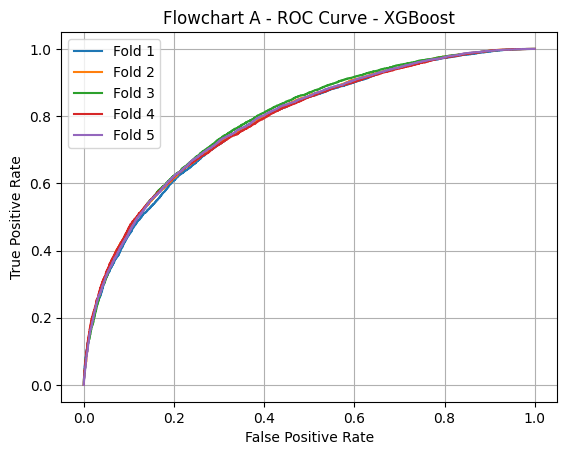

Total time: 91.91 seconds


In [ ]:
# XGBoost Model - Flowchart A
# Custom metric function
def evaluate_metrics(y_true, y_pred, y_score):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_score)
    }

# Load preprocessed data
df = pd.read_csv("higgs_preprocessed.csv")
X = df.drop("label", axis=1)
y = df["label"]

MODEL_NAME = "XGBoost"
SAVE_PATH = f"/content/drive/MyDrive/flowchart_A_results_{MODEL_NAME}.csv"
force_restart = True  # set to False to resume if results exist

# Define lightweight parameters for fast XGBoost
xgb_params = {
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "n_estimators": 50,
    "max_depth": 3,
    "random_state": 42,
    "verbosity": 0
}

# Resume logic
if os.path.exists(SAVE_PATH) and not force_restart:
    results = pd.read_csv(SAVE_PATH).to_dict("records")
    start_fold = len(results) + 1
    print(f"Resuming from fold {start_fold}")
else:
    results = []
    start_fold = 1

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_data = []
start_time = time.time()

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    if fold < start_fold:
        continue

    print(f"\n[XGBoost] Outer Fold {fold}")
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    best_features = None
    best_score = -np.inf
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=fold)

    for method in [mutual_info_classif, f_classif]:
        selector = SelectKBest(score_func=method, k=15)
        X_inner_selected = selector.fit_transform(X_train_outer, y_train_outer)
        model = XGBClassifier(**xgb_params)
        score = cross_val_score(model, X_inner_selected, y_train_outer,
                                 cv=inner_cv, scoring="roc_auc", n_jobs=-1).mean()
        if score > best_score:
            best_score = score
            best_features = selector.get_support()

    selected_cols = X.columns[best_features]
    X_train_final = X_train_outer[selected_cols]
    X_test_final = X_test_outer[selected_cols]

    model = XGBClassifier(**xgb_params)
    model.fit(X_train_final, y_train_outer)
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_outer, y_proba)
    roc_data.append((fpr, tpr))

    metrics = evaluate_metrics(y_test_outer, y_pred, y_proba)
    results.append(metrics)
    pd.DataFrame(results).to_csv(SAVE_PATH, index=False)

# Plot ROC curves
for i, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Fold {i+1}")
plt.title(f"Flowchart A - ROC Curve - {MODEL_NAME}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

print(f"Total time: {time.time() - start_time:.2f} seconds")


In [22]:
# Summary of Performance Metrics for Flowchart A (All Models):

# Location where the result CSVs are saved
base_path = "/content/drive/MyDrive/"
model_names = ["KNN", "SVM", "MLP", "XGBoost"]

all_results = []

for model in model_names:
    file_path = os.path.join(base_path, f"flowchart_A_results_{model}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["model"] = model
        all_results.append(df)
    else:
        print(f"⚠️ Warning: File not found for {model}: {file_path}")

# Combine all model results
df_all = pd.concat(all_results, ignore_index=True)

# Compute mean and std of metrics for each model
summary = df_all.groupby("model").agg(["mean", "std"]).round(4)

# Optional: Flatten the multi-level columns
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

# Reorder columns (optional, for clarity)
metric_order = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
ordered_cols = []
for m in metric_order:
    ordered_cols += [f"{m}_mean", f"{m}_std"]

summary = summary[ordered_cols]

# Display
print("\n🔍 Summary of Performance Metrics for Flowchart A (All Models):\n")
display(summary)

# Save to file
summary.to_csv(os.path.join(base_path, "flowchart_A_summary_metrics.csv"))



🔍 Summary of Performance Metrics for Flowchart A (All Models):



,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_score_mean,f1_score_std,roc_auc_mean,roc_auc_std
model,,,,,,,,,,
KNN,0.6472,0.0044,0.6563,0.0040,0.6976,0.0050,0.6763,0.0041,0.6924,0.0046
MLP,0.7079,0.0031,0.7247,0.0048,0.7210,0.0117,0.7228,0.0047,0.7788,0.0023
SVM,0.7020,0.0033,0.6969,0.0045,0.7715,0.0049,0.7323,0.0025,0.7694,0.0036
XGBoost,0.7116,0.0034,0.7229,0.0032,0.7364,0.0049,0.7296,0.0035,0.7871,0.0035


In [ ]:
# ************ Flowchart B – Step 1: Setup & Feature Selection *****************
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Load preprocessed dataset
df = pd.read_csv("higgs_preprocessed.csv")

# Split features and label
X = df.drop("label", axis=1)
y = df["label"]

# 🧠 Apply filter-based feature selection ONCE before inner CV
selector = SelectKBest(score_func=mutual_info_classif, k=15)
X_selected = selector.fit_transform(X, y)
selected_feature_names = X.columns[selector.get_support()]
print("Selected Features for Flowchart B:", selected_feature_names.tolist())

# Create a reduced DataFrame with selected features
X = pd.DataFrame(X_selected, columns=selected_feature_names)

# Setup base model parameters and hyperparameter grids
model_params = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": list(range(3, 12, 2))}
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {"C": [0.1, 1, 10], "kernel": ['linear', 'rbf']}
    },
    "MLP": {
        "model": MLPClassifier(max_iter=300),
        "params": {"hidden_layer_sizes": [(50,), (100,)], "activation": ['relu', 'tanh']}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
        "params": {"n_estimators": [50, 100], "max_depth": [3, 5]}
    }
}

print("✅ Flowchart B setup complete. You can now proceed to the model-specific cross-validation and hyperparameter tuning loop.")


Selected Features for Flowchart B: ['feature_1', 'feature_4', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_13', 'feature_18', 'feature_19', 'feature_22', 'feature_23', 'feature_25', 'feature_26', 'feature_27', 'feature_28']
✅ Flowchart B setup complete. You can now proceed to the model-specific cross-validation and hyperparameter tuning loop.



[KNN] Outer Fold 1
Fold 1 done. Best Params: {'n_neighbors': 11}, Accuracy: 0.6714

[KNN] Outer Fold 2
Fold 2 done. Best Params: {'n_neighbors': 11}, Accuracy: 0.6738

[KNN] Outer Fold 3
Fold 3 done. Best Params: {'n_neighbors': 11}, Accuracy: 0.6736

[KNN] Outer Fold 4
Fold 4 done. Best Params: {'n_neighbors': 11}, Accuracy: 0.6707

[KNN] Outer Fold 5
Fold 5 done. Best Params: {'n_neighbors': 11}, Accuracy: 0.6671


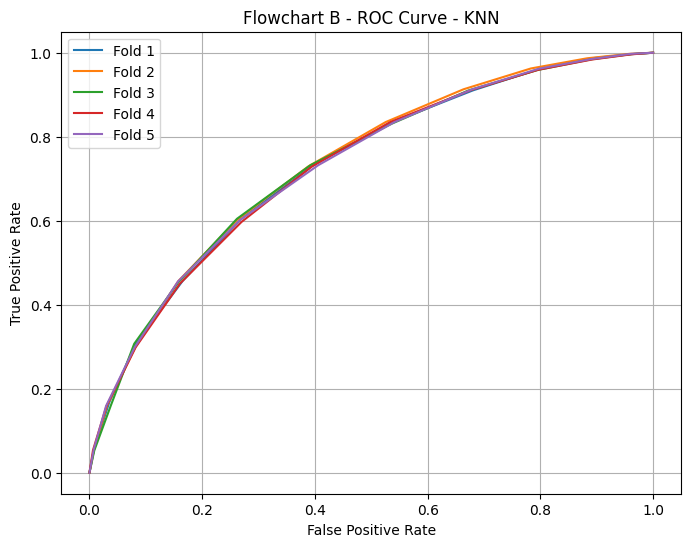


✅ Completed Flowchart B for KNN. Total time: 2430.73 seconds


In [ ]:
# ******************** Flowchart B – KNN Nested Cross-Validation *************************

MODEL_NAME = "KNN"
SAVE_PATH = f"/content/drive/MyDrive/flowchart_B_results_{MODEL_NAME}.csv"

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

param_grid = model_params[MODEL_NAME]["params"]
base_model = model_params[MODEL_NAME]["model"]

results = []
roc_data = []
start_time = time.time()

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"\n[{MODEL_NAME}] Outer Fold {fold}")

    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    # Grid search on inner CV
    grid = GridSearchCV(base_model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_outer, y_train_outer)

    best_model = grid.best_estimator_

    # Train final model on outer training set
    best_model.fit(X_train_outer, y_train_outer)
    y_pred = best_model.predict(X_test_outer)
    y_proba = best_model.predict_proba(X_test_outer)[:, 1]

    # Evaluate
    metrics = {
        "accuracy": accuracy_score(y_test_outer, y_pred),
        "precision": precision_score(y_test_outer, y_pred, zero_division=0),
        "recall": recall_score(y_test_outer, y_pred, zero_division=0),
        "f1_score": f1_score(y_test_outer, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test_outer, y_proba)
    }
    results.append(metrics)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_outer, y_proba)
    roc_data.append((fpr, tpr))

    print(f"Fold {fold} done. Best Params: {grid.best_params_}, Accuracy: {metrics['accuracy']:.4f}")

# Save results
pd.DataFrame(results).to_csv(SAVE_PATH, index=False)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Fold {i+1}")
plt.title(f"Flowchart B - ROC Curve - {MODEL_NAME}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

print(f"\n✅ Completed Flowchart B for {MODEL_NAME}. Total time: {time.time() - start_time:.2f} seconds")


🔄 Resuming from fold 3

[SVM] Outer Fold 3
✅ Fold 3 done. Accuracy: 0.6446, Best Params: {'svm__C': 1, 'svm__kernel': 'linear'}

[SVM] Outer Fold 4
✅ Fold 4 done. Accuracy: 0.6367, Best Params: {'svm__C': 1, 'svm__kernel': 'linear'}

[SVM] Outer Fold 5
✅ Fold 5 done. Accuracy: 0.6423, Best Params: {'svm__C': 1, 'svm__kernel': 'linear'}


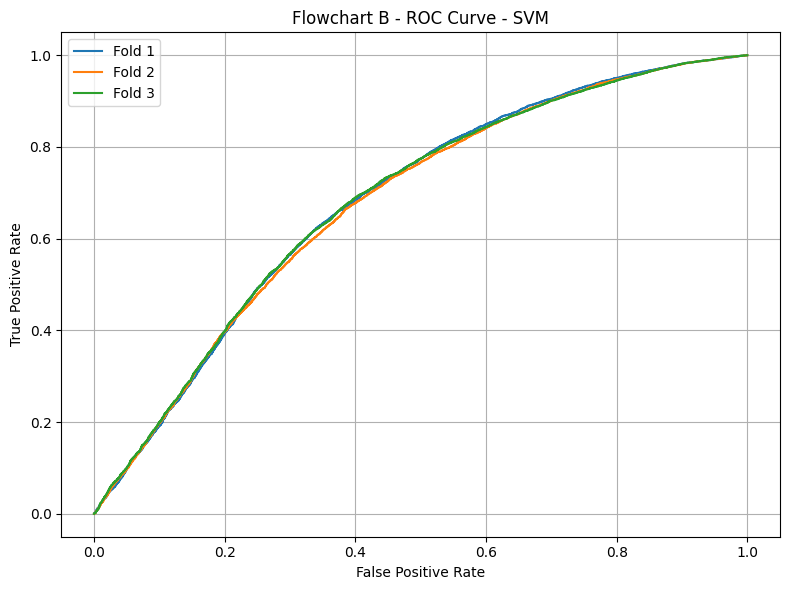


🏁 Completed Flowchart B for SVM in 5158.81 seconds.


In [33]:
# ======================= Flowchart B – SVM  ========================
import time, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# === Setup ===
MODEL_NAME = "SVM"
SAVE_PATH = f"/content/drive/MyDrive/flowchart_B_results_{MODEL_NAME}.csv"

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

# === Load Data ===
df = pd.read_csv("higgs_preprocessed.csv")
X = df.drop("label", axis=1)
y = df["label"]

# === Hyperparameter Grid ===
param_grid = {
    "svm__C": [0.1, 1],
    "svm__kernel": ["linear"]
}

# === Resume Support ===
results = []
roc_data = []
start_fold = 1

if os.path.exists(SAVE_PATH):
    existing_df = pd.read_csv(SAVE_PATH)
    results = existing_df.to_dict('records')
    start_fold = len(results) + 1
    print(f"🔄 Resuming from fold {start_fold}")

# === Outer Cross-Validation Loop ===
start_time = time.time()
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    if fold < start_fold:
        continue

    print(f"\n[{MODEL_NAME}] Outer Fold {fold}")

    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    # === Define Pipeline ===
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('selector', SelectKBest(mutual_info_classif, k=15)),
        ('svm', SVC())  # no probability=True for speed
    ])

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    # === Train with Inner CV ===
    grid.fit(X_train_outer, y_train_outer)
    best_model = grid.best_estimator_

    # === Final Evaluation on Outer Test Fold ===
    y_pred = best_model.predict(X_test_outer)
    decision_scores = best_model.decision_function(X_test_outer)

    # Scale decision function scores for ROC curve
    score_scaler = MinMaxScaler()
    y_score = score_scaler.fit_transform(decision_scores.reshape(-1, 1)).ravel()

    # === Metrics ===
    metrics = {
        "fold": fold,
        "accuracy": accuracy_score(y_test_outer, y_pred),
        "precision": precision_score(y_test_outer, y_pred, zero_division=0),
        "recall": recall_score(y_test_outer, y_pred, zero_division=0),
        "f1_score": f1_score(y_test_outer, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test_outer, y_score),
        "best_C": grid.best_params_["svm__C"],
        "best_kernel": grid.best_params_["svm__kernel"]
    }
    results.append(metrics)

    # === ROC Curve Data ===
    fpr, tpr, _ = roc_curve(y_test_outer, y_score)
    roc_data.append((fpr, tpr))

    # === Save After Each Fold ===
    pd.DataFrame(results).to_csv(SAVE_PATH, index=False)
    print(f"✅ Fold {fold} done. Accuracy: {metrics['accuracy']:.4f}, Best Params: {grid.best_params_}")

# === Plot ROC Curves ===
plt.figure(figsize=(8, 6))
for i, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Fold {i+1}")
plt.title(f"Flowchart B - ROC Curve - {MODEL_NAME}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n🏁 Completed Flowchart B for {MODEL_NAME} in {time.time() - start_time:.2f} seconds.")



[MLP] Outer Fold 1
✅ Fold 1 done. Accuracy: 0.7181, Best Params: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,)}

[MLP] Outer Fold 2
✅ Fold 2 done. Accuracy: 0.7127, Best Params: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,)}

[MLP] Outer Fold 3
✅ Fold 3 done. Accuracy: 0.7181, Best Params: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,)}

[MLP] Outer Fold 4
✅ Fold 4 done. Accuracy: 0.7108, Best Params: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (50,)}

[MLP] Outer Fold 5
✅ Fold 5 done. Accuracy: 0.7088, Best Params: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,)}


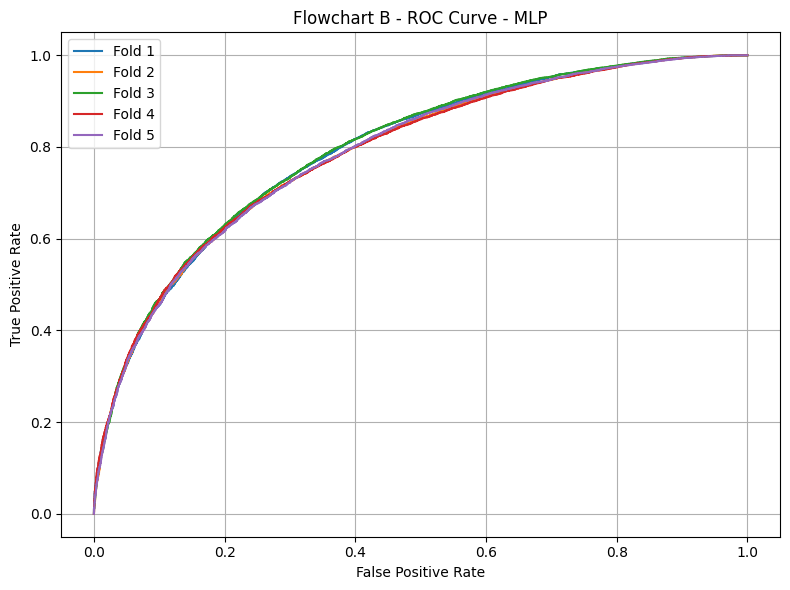


🏁 Completed Flowchart B for MLP in 5315.19 seconds.


In [18]:
# ======================= Flowchart B – MLP ========================
import time, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# === Setup ===
MODEL_NAME = "MLP"
SAVE_PATH = f"/content/drive/MyDrive/flowchart_B_results_{MODEL_NAME}.csv"

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

# === Load Data ===
df = pd.read_csv("higgs_preprocessed.csv")
X = df.drop("label", axis=1)
y = df["label"]

# === Hyperparameter Grid ===
param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,)],
    "mlp__activation": ["relu", "tanh"]
}

# === Resume Support ===
results = []
roc_data = []
start_fold = 1

# === Force rerun from scratch by deleting saved results ===
if os.path.exists(SAVE_PATH):
    os.remove(SAVE_PATH)

# === Outer Cross-Validation Loop ===
start_time = time.time()
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    if fold < start_fold:
        continue

    print(f"\n[{MODEL_NAME}] Outer Fold {fold}")

    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    # === Define Pipeline ===
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('selector', SelectKBest(mutual_info_classif, k=15)),
        ('mlp', MLPClassifier(max_iter=300, random_state=fold))
    ])

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    # === Train with Inner CV ===
    grid.fit(X_train_outer, y_train_outer)
    best_model = grid.best_estimator_

    # === Final Evaluation on Outer Test Fold ===
    y_pred = best_model.predict(X_test_outer)
    y_proba = best_model.predict_proba(X_test_outer)[:, 1]

    # === Metrics ===
    metrics = {
        "fold": fold,
        "accuracy": accuracy_score(y_test_outer, y_pred),
        "precision": precision_score(y_test_outer, y_pred, zero_division=0),
        "recall": recall_score(y_test_outer, y_pred, zero_division=0),
        "f1_score": f1_score(y_test_outer, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test_outer, y_proba),
        "best_hidden_layer_sizes": grid.best_params_["mlp__hidden_layer_sizes"],
        "best_activation": grid.best_params_["mlp__activation"]
    }
    results.append(metrics)

    # === ROC Curve Data ===
    fpr, tpr, _ = roc_curve(y_test_outer, y_proba)
    roc_data.append((fpr, tpr))

    # === Save After Each Fold ===
    pd.DataFrame(results).to_csv(SAVE_PATH, index=False)
    print(f"✅ Fold {fold} done. Accuracy: {metrics['accuracy']:.4f}, Best Params: {grid.best_params_}")

# === Plot ROC Curves ===
plt.figure(figsize=(8, 6))
for i, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Fold {i+1}")
plt.title(f"Flowchart B - ROC Curve - {MODEL_NAME}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n🏁 Completed Flowchart B for {MODEL_NAME} in {time.time() - start_time:.2f} seconds.")



[XGBoost] Outer Fold 1
✅ Fold 1 done. Accuracy: 0.7169, Best Params: {'xgb__max_depth': 5, 'xgb__n_estimators': 100}

[XGBoost] Outer Fold 2
✅ Fold 2 done. Accuracy: 0.7111, Best Params: {'xgb__max_depth': 3, 'xgb__n_estimators': 100}

[XGBoost] Outer Fold 3
✅ Fold 3 done. Accuracy: 0.7205, Best Params: {'xgb__max_depth': 5, 'xgb__n_estimators': 100}

[XGBoost] Outer Fold 4
✅ Fold 4 done. Accuracy: 0.7151, Best Params: {'xgb__max_depth': 5, 'xgb__n_estimators': 50}

[XGBoost] Outer Fold 5
✅ Fold 5 done. Accuracy: 0.7016, Best Params: {'xgb__max_depth': 5, 'xgb__n_estimators': 50}


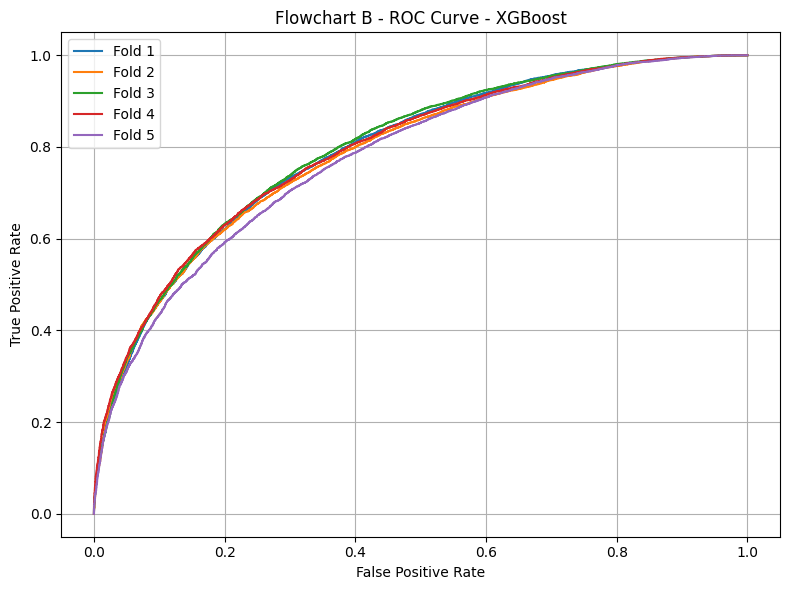


🏁 Completed Flowchart B for XGBoost in 554.81 seconds.


In [15]:
# ======================= Flowchart B – XGBoost ========================

# === Setup ===
MODEL_NAME = "XGBoost"
SAVE_PATH = f"/content/drive/MyDrive/flowchart_B_results_{MODEL_NAME}.csv"

# Load dataset
df = pd.read_csv("higgs_preprocessed.csv")
X = df.drop("label", axis=1)
y = df["label"]

# Cross-validation setup
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

# Hyperparameter grid (modest for speed)
param_grid = {
    "xgb__n_estimators": [50, 100],
    "xgb__max_depth": [3, 5]
}

# Resume support
results = []
roc_data = []
start_fold = 1

if os.path.exists(SAVE_PATH):
    existing_df = pd.read_csv(SAVE_PATH)
    results = existing_df.to_dict('records')
    start_fold = len(results) + 1
    print(f"🔄 Resuming from fold {start_fold}")

# Start timer
start_time = time.time()

# === Outer CV Loop ===
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    if fold < start_fold:
        continue

    print(f"\n[{MODEL_NAME}] Outer Fold {fold}")

    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    # Pipeline: scaling + feature selection + XGBoost
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('selector', SelectKBest(score_func=mutual_info_classif, k=15)),
        ('xgb', XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            verbosity=0,
            n_jobs=-1
        ))
    ])

    # Grid search
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    # Fit model
    grid.fit(X_train_outer, y_train_outer)
    best_model = grid.best_estimator_

    # Evaluate on outer test fold
    y_pred = best_model.predict(X_test_outer)
    y_proba = best_model.predict_proba(X_test_outer)[:, 1]

    # Metrics
    metrics = {
        "fold": fold,
        "accuracy": accuracy_score(y_test_outer, y_pred),
        "precision": precision_score(y_test_outer, y_pred, zero_division=0),
        "recall": recall_score(y_test_outer, y_pred, zero_division=0),
        "f1_score": f1_score(y_test_outer, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test_outer, y_proba),
        "best_n_estimators": grid.best_params_["xgb__n_estimators"],
        "best_max_depth": grid.best_params_["xgb__max_depth"]
    }
    results.append(metrics)

    # ROC Curve Data
    fpr, tpr, _ = roc_curve(y_test_outer, y_proba)
    roc_data.append((fpr, tpr))

    # Save after each fold
    pd.DataFrame(results).to_csv(SAVE_PATH, index=False)
    print(f"✅ Fold {fold} done. Accuracy: {metrics['accuracy']:.4f}, Best Params: {grid.best_params_}")

# === Plot ROC Curves ===
plt.figure(figsize=(8, 6))
for i, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Fold {i+1}")
plt.title(f"Flowchart B - ROC Curve - {MODEL_NAME}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n🏁 Completed Flowchart B for {MODEL_NAME} in {time.time() - start_time:.2f} seconds.")


In [26]:
# ===== Summary of Performance Metrics for Flowchart B (All Models)===========
# Define model names and paths
model_names = ["KNN", "SVM", "MLP", "XGBoost"]
base_path = "/content/drive/MyDrive/"
summary = {}

for model in model_names:
    try:
        file_path = base_path + f"flowchart_B_results_{model}.csv"
        df = pd.read_csv(file_path)

        # Only keep relevant metrics (ignore hyperparameters columns if present)
        relevant_metrics = ["accuracy", "precision", "recall", "f1_score", "roc_auc"]
        df_cleaned = df[relevant_metrics].copy()

        summary[model] = df_cleaned.mean()

    except Exception as e:
        print(f"⚠️ Could not process {model}: {e}")
        summary[model] = pd.Series({m: None for m in relevant_metrics})

# Combine into one DataFrame
summary_df = pd.DataFrame(summary).T  # transpose so models are rows
summary_df = summary_df.round(4)
summary_df.columns = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

# Show final summary table
print("📊 Summary of Performance Metrics - Flowchart B")
display(summary_df)


📊 Summary of Performance Metrics - Flowchart B


,Accuracy,Precision,Recall,F1 Score,ROC AUC
KNN,0.6713,0.6742,0.7314,0.7016,0.7318
SVM,0.6397,0.6239,0.8009,0.7014,0.6775
MLP,0.7137,0.7358,0.7168,0.7254,0.7913
XGBoost,0.7131,0.7246,0.7370,0.7308,0.7905


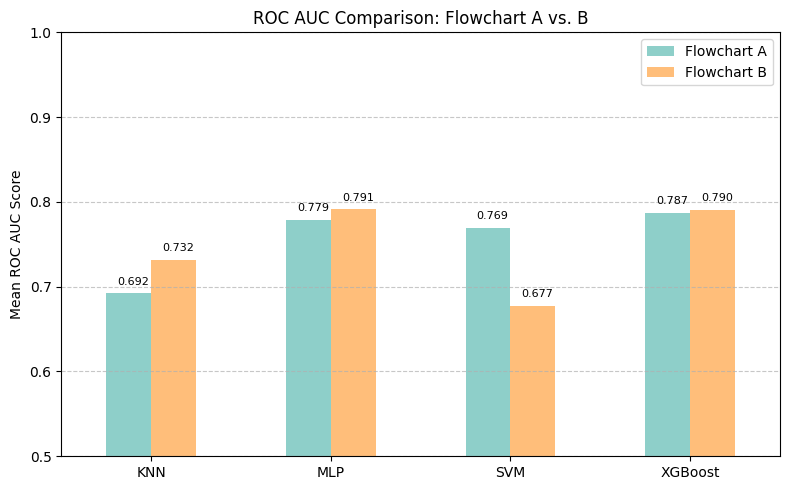

In [28]:
# === Load Flowchart A Summary ===
summary_a_path = os.path.join(base_path, "flowchart_A_summary_metrics.csv")
summary_a = pd.read_csv(summary_a_path, index_col=0)

# Extract AUC scores
auc_a = summary_a["roc_auc_mean"]

# === Load Flowchart B Summary ===
summary_b = summary_df  # From your flowchart B code (already prepared)

# Align models just in case
common_models = sorted(set(auc_a.index) & set(summary_b.index))
auc_b = summary_b.loc[common_models, "ROC AUC"]
auc_a = auc_a.loc[common_models]

# === Combine into a single DataFrame for plotting ===
auc_combined = pd.DataFrame({
    "Flowchart A": auc_a,
    "Flowchart B": auc_b
})

# === Plot ===
auc_combined.plot(kind="bar", figsize=(8, 5), color=["#8ECFC9", "#FFBE7A"])
plt.title("ROC AUC Comparison: Flowchart A vs. B")
plt.ylabel("Mean ROC AUC Score")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate bar values
for idx, model in enumerate(auc_combined.index):
    for j, val in enumerate(auc_combined.loc[model]):
        plt.text(idx + j*0.25 - 0.1, val + 0.01, f"{val:.3f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()
